# Astropy Modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models

%matplotlib inline

In [2]:
g = models.Gaussian1D(amplitude=0.4, mean=0., stddev=1.)
print(g)
g.amplitude = 0.4
print(g)
print(g(0.5))
g(np.linspace(0.5, 1.5, 7))

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude mean stddev
    --------- ---- ------
          0.4  0.0    1.0
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude mean stddev
    --------- ---- ------
          0.4  0.0    1.0
0.3529987610338382


array([0.35299876, 0.32029496, 0.28265931, 0.24261226, 0.20253425,
       0.16444492, 0.12986099])

## Simple 1-D model fitting

(200,)
<class 'astropy.modeling.functional_models.Gaussian1D'>
Name: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Fittable parameters: ('amplitude', 'mean', 'stddev') --------
<class 'astropy.modeling.fitting.LevMarLSQFitter'> ------- <class 'astropy.modeling.functional_models.Gaussian1D'>
Name: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Fittable parameters: ('amplitude', 'mean', 'stddev')


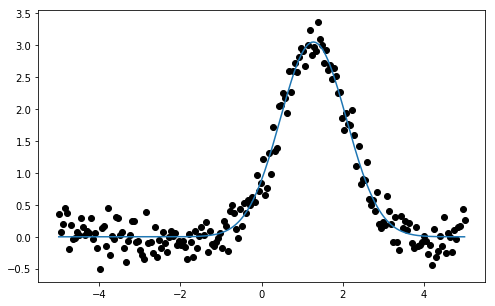

In [3]:
# Fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x-1.3)**2/0.8**2)
y += np.random.normal(0., 0.2, x.shape)
print(x.shape)

# Fit the data using a box model
t_init = models.Trapezoid1D(amplitude=1., x_0=0., width=1., slope=0.5)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y)

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=2., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)
print(type(g_init), "--------")
print(type(fit_g), "-------", type(g))

# Pltting data with best-ft model
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'ko')
# plt.plot(x, t(x), label='trapezoid')
plt.plot(x, g(x), label='gaussian')

## Compound Models

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7080234421046137
            Iterations: 14
            Function evaluations: 136
            Gradient evaluations: 14


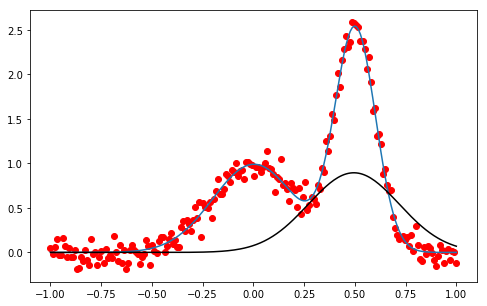

In [4]:
# Generate fake data
np.random.seed(42)
g1 = models.Gaussian1D(1, 0, 0.2)
g2 = models.Gaussian1D(2.5, 0.5, 0.1)
x = np.linspace(-1, 1, 200)
y = g1(x) + g2(x) + np.random.normal(0., 0.1, x.shape)

# Now to fit the data
gg_init = models.Gaussian1D(1, 0, 0.1) + models.Gaussian1D(2, 0.5, 0.1)
fitter = fitting.SLSQPLSQFitter()
gg_fit = fitter(gg_init, x, y)

# Convolution of two models gives a compound model
g3 = convolve_models(g1, g2)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ro')
plt.plot(x, gg_fit(x))
plt.plot(x, g3(x), 'k-')

# The Stingray Modeling API

In [5]:
from astropy.modeling.fitting import _fitter_to_model_params

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


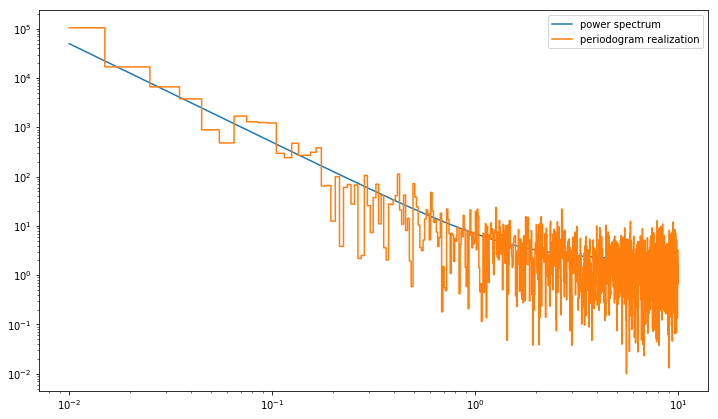

In [6]:
# define power law component
pl = models.PowerLaw1D(amplitude=5.0, alpha=2.0)

# fix x_0 of power law component
pl.x_0.fixed = True

# define constant
c = models.Const1D(amplitude=2.0)

# make compound model
plc = pl + c

# parameters for fake data.
# alpha = 2.0
# amplitude = 5.0
# white_noise = 2.0

# frequency array
freq = np.linspace(0.01, 10.0, 10.0/0.01)

# _fitter_to_model_params(plc, [amplitude, alpha, white_noise])
psd_shape = plc(freq)

# adding noise
powers = psd_shape*np.random.chisquare(2, size=psd_shape.shape[0])/2.0

# result
plt.figure(figsize=(12,7))
plt.loglog(freq, psd_shape, label="power spectrum")
plt.loglog(freq, powers, linestyle="steps-mid", label="periodogram realization")
plt.legend()

## Fitting a powerspectrum with some model

In [7]:
from stingray import Powerspectrum
from stingray.modeling import PSDLogLikelihood, PSDPosterior, PSDParEst
from stingray.modeling.scripts import fit_powerspectrum, fit_lorentzians

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Model: CompoundModel3
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <PowerLaw1D(amplitude=1., x_0=1., alpha=1.)>

    [1]: <Const1D(amplitude=1.)>
Parameters:
    amplitude_0 x_0_0 alpha_0 amplitude_1
    ----------- ----- ------- -----------
            1.0   1.0     1.0         1.0


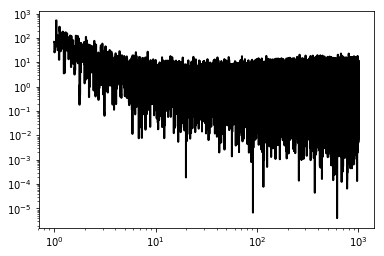

In [8]:
m = 1
nfreq = 100000
freq = np.linspace(1, 1000, nfreq)

np.random.seed(50)  # set the seed for the random number generator
noise = np.random.exponential(size=nfreq)

model = models.PowerLaw1D() + models.Const1D()
print(model)

model.x_0_0.fixed = True

alpha_0 = 2.0
amplitude_0 = 100.0
amplitude_1 = 2.0

model.alpha_0 = alpha_0
model.amplitude_0 = amplitude_0
model.amplitude_1 = amplitude_1

# fitting to create data and then add noise
p = model(freq)
power = noise * p

# creating a power spectrum
ps = Powerspectrum()
ps.freq = freq
ps.power = power
ps.m = m
ps.df = freq[1] - freq[0]
ps.norm = "leahy"

# plotting
plt.figure()
plt.loglog(ps.freq, ps.power, linestyle="steps-mid", lw=2, color="black")

Model: CompoundModel4
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <PowerLaw1D(amplitude=1., x_0=1., alpha=1.)>

    [1]: <Const1D(amplitude=1.)>
Parameters:
    amplitude_0 x_0_0 alpha_0 amplitude_1
    ----------- ----- ------- -----------
            1.0   1.0     1.0         1.0


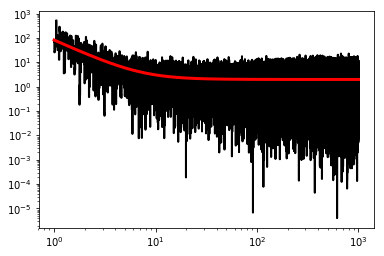

In [9]:
# Fitting model
model_to_test = models.PowerLaw1D() + models.Const1D()
print(model_to_test)
model_to_test.x_0_0.fixed = True

t0 = [80, 1.5, 2.5]
parest, res = fit_powerspectrum(ps, model_to_test, t0)

# plotting
plt.figure()
plt.loglog(ps.freq, ps.power, linestyle="steps-mid", lw=2, color="black")
plt.plot(ps.freq, res.mfit, lw=3, color="red")

## Fitting Lorentzians

Model: CompoundModel7
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Lorentz1D(amplitude=150., x_0=0.5, fwhm=0.1)>

    [1]: <Lorentz1D(amplitude=50., x_0=2., fwhm=1.)>

    [2]: <Lorentz1D(amplitude=15., x_0=7.5, fwhm=0.5)>

    [3]: <Const1D(amplitude=2.)>
Parameters:
    amplitude_0 x_0_0 fwhm_0 amplitude_1 ... amplitude_2 x_0_2 fwhm_2 amplitude_3
    ----------- ----- ------ ----------- ... ----------- ----- ------ -----------
          150.0   0.5    0.1        50.0 ...        15.0   7.5    0.5         2.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


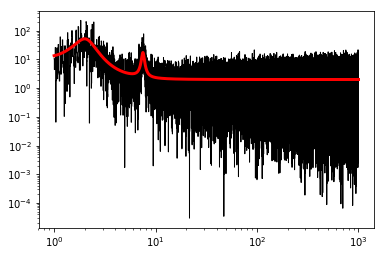

In [10]:
np.random.seed(100)
nlor = 3

freq = np.linspace(0.01, 10.0, 10.0/0.01)

x_0_0 = 0.5
x_0_1 = 2.0
x_0_2 = 7.5

amplitude_0 = 150.0
amplitude_1 = 50.0
amplitude_2 = 15.0

fwhm_0 = 0.1
fwhm_1 = 1.0
fwhm_2 = 0.5

whitenoise = 2.0

model = models.Lorentz1D(amplitude_0, x_0_0, fwhm_0) + \
        models.Lorentz1D(amplitude_1, x_0_1, fwhm_1) + \
        models.Lorentz1D(amplitude_2, x_0_2, fwhm_2) + \
        models.Const1D(whitenoise)
print(model)

p = model(ps.freq)
noise = np.random.exponential(size=len(ps.freq))

power = p*noise
plt.figure()
plt.loglog(ps.freq, power, lw=1, linestyle="steps-mid", c="black")
plt.loglog(ps.freq, p, lw=3, color="red")

In [11]:
print(freq.shape, power.shape)

(1000,) (100000,)


### Creating a `Powerspectrum` class and then use `fit_lorentzians`  function

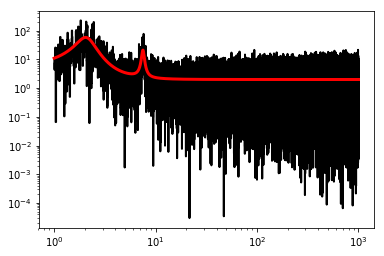

In [12]:
import copy
ps_new = copy.copy(ps)
ps_new.power = power


# plotting
plt.figure()
plt.loglog(ps_new.freq, ps_new.power, linestyle="steps-mid", lw=2, color="black")

t0 = [150, 0.4, 0.2, 50, 2.3, 0.6, 20, 8.0, 0.4, 2.1]
parest, res = fit_lorentzians(ps_new, nlor, t0)
plt.plot(ps_new.freq, res.mfit, lw=3, color="red")

# Likelihoods and Posteriors

In [13]:
from astropy.modeling.fitting import _fitter_to_model_params
from stingray.modeling import PSDParEst, PSDPosterior
import scipy.stats

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


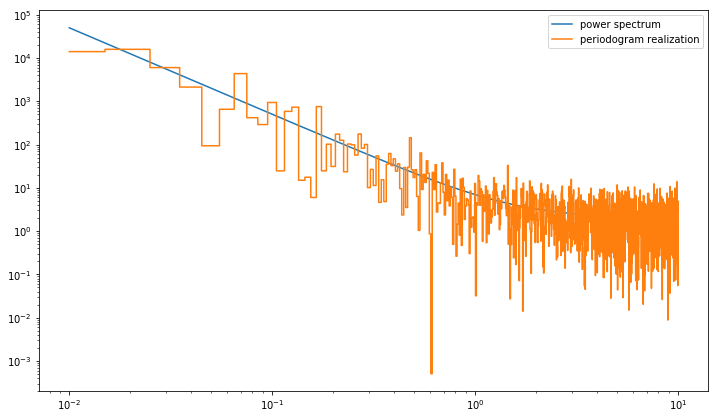

In [14]:
# define power law component
pl = models.PowerLaw1D()

# fix x_0 of power law component
pl.x_0.fixed = True

# define constant
c = models.Const1D()

# make compound model
plc = pl + c

# parameters for fake data.
alpha = 2.0
amplitude = 5.0
white_noise = 2.0

freq = np.linspace(0.01, 10.0, 10.0/0.01)

# Putting parameters into the model
_fitter_to_model_params(plc, [amplitude, alpha, white_noise])
psd_shape = plc(freq)

# Adding noise from chi-square distribution with 2 degrees of freedom
powers = psd_shape*np.random.chisquare(2, size=psd_shape.shape[0])/2.0

# Plotting PSD
plt.figure(figsize=(12,7))
plt.loglog(freq, psd_shape, label="power spectrum") # Before adding noise
plt.loglog(freq, powers, linestyle="steps-mid", label="periodogram realization") # After adding noise
plt.legend()

In [15]:
# Using PSDLogLikelihood to calculate log-likelihood
ps = Powerspectrum()
ps.freq = freq
ps.power = powers
ps.df = ps.freq[1] - ps.freq[0]
ps.m = 1

loglike = PSDLogLikelihood(ps.freq, ps.power, plc, m=1)
test_pars = [1, 5, 100]
loglike(test_pars, neg=True)
loglike.model.parameters

array([  1.,   1.,   5., 100.])

In [16]:
parest = PSDParEst(ps, fitmethod="L-BFGS-B", max_post=True)
starting_pars = [2.0, 5.0, 2.0]
res = parest.fit(loglike, starting_pars)

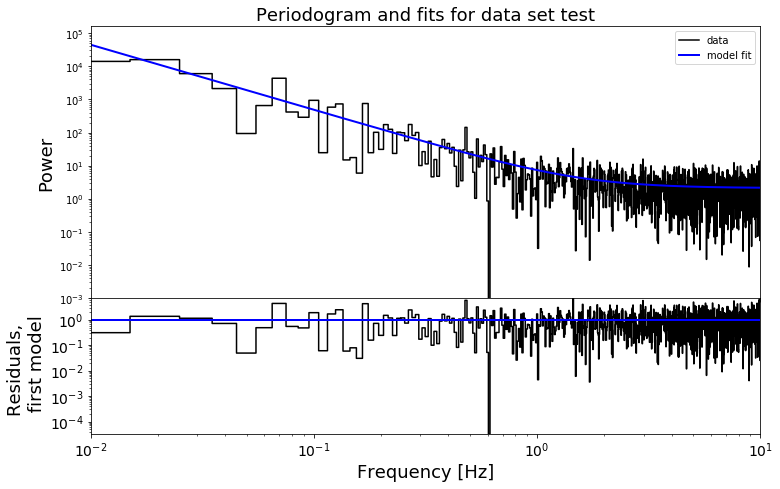

In [17]:
res.result
parest.plotfits(res) # Using built-in function

In [18]:
print(res.p_opt) # Max Likelihood
print(res.err) # Uncertainity

[5.26731446 1.96445382 2.11424281]
[0.61024375 0.10279961 0.13536959]


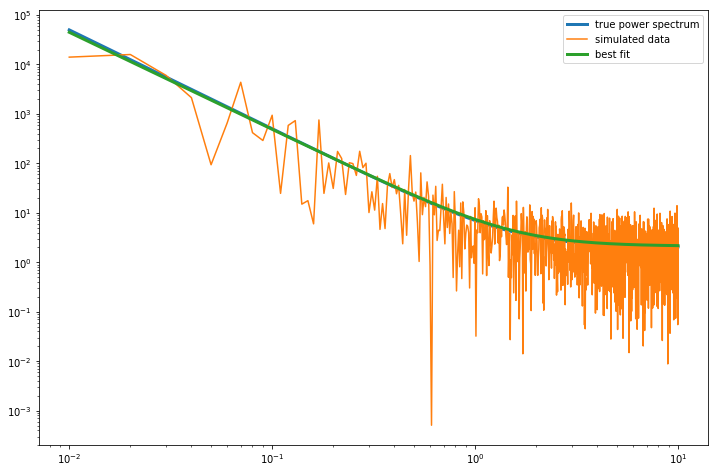

In [19]:
# Plotting
plt.figure(figsize=(12,8))
plt.loglog(ps.freq, psd_shape, label="true power spectrum",lw=3)
plt.loglog(ps.freq, ps.power, label="simulated data")
plt.loglog(ps.freq, res.mfit, label="best fit", lw=3)
plt.legend()

In [20]:
# Summary
#Note: `res` is an OptimizationResults object
res.print_summary(loglike)

The best-fit model parameters plus errors are:
  0) Parameter amplitude_0         : 
5.26731              +/- 0.61024              
[      None       None]
  1) Parameter x_0_0               : 
1.00000              (Fixed) 
  2) Parameter alpha_0             : 
1.96445              +/- 0.10280              
[      None       None]
  3) Parameter amplitude_1         : 
2.11424              +/- 0.13537              
[      None       None]


Fitting statistics: 
 -- number of data points: 1000
 -- Deviance [-2 log L] D = 4428.394241.3
 -- The Akaike Information Criterion of the model is: 2220.197120334253.
 -- The Bayesian Information Criterion of the model is: 2234.9203861711994.
 -- The figure-of-merit function for this model  is: 1022.930225.5f and the fit for 997 dof is 1.026008.3f
 -- Summed Residuals S = -25505.078442.5f
 -- Expected S ~ 6000.000000.5 +/- 109.544512.5


# Bayesian Parameter Estimation

In [21]:
# flat prior for the power law index
p_alpha = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))
# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((0.01 <= amplitude) & (amplitude <= 10.0))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors = {}
priors["alpha_0"] = p_alpha
priors["amplitude_0"] = p_amplitude
priors["amplitude_1"] = p_whitenoise

lpost = PSDPosterior(ps.freq, ps.power, plc, m=ps.m, priors=priors)

In [22]:
# calculating log-posterior for a given set of params
test_pars = [1.0, 2.0, 4.0]
print("log-prior: " + str(lpost.logprior(test_pars)))
print("log-likelihood: " + str(lpost.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost(test_pars)))

log-prior: -198.61635344021062
log-likelihood: -2412.842000735216
log-posterior: -2611.458354175427


In [23]:
# Param estimation using Stingray wrapper
parest = PSDParEst(ps, fitmethod='BFGS', max_post=True)
starting_pars = test_pars = [5.0, 2.0, 2.0]
res = parest.fit(lpost, starting_pars)
print("best-fit parameters:")
for p,e in zip(res.p_opt, res.err):
    print("%.4f +/- %.4f"%(p,e))

best-fit parameters:
5.4755 +/- 0.5901
1.9366 +/- 0.0863
2.0558 +/- 0.0682


In [24]:
# Summary
res.print_summary(lpost)

The best-fit model parameters plus errors are:
The best-fit model parameters plus errors are:
  0) Parameter amplitude_0         : 
  0) Parameter amplitude_0         : 
5.47550              +/- 0.59012              
5.47550              +/- 0.59012              
[      None       None]
[      None       None]
  1) Parameter x_0_0               : 
  1) Parameter x_0_0               : 
1.00000              (Fixed) 
1.00000              (Fixed) 
  2) Parameter alpha_0             : 
  2) Parameter alpha_0             : 
1.93656              +/- 0.08627              
1.93656              +/- 0.08627              
[      None       None]
[      None       None]
  3) Parameter amplitude_1         : 
  3) Parameter amplitude_1         : 
2.05579              +/- 0.06816              
2.05579              +/- 0.06816              
[      None       None]
[      None       None]




Fitting statistics: 
Fitting statistics: 
 -- number of data points: 1000
 -- number of data points: 1000
 -- De